# Clase Práctica #6 (Compilación)

In [1]:
import pydot

## Autómatas finitos

Un autómata finito (determinista o no determinista) es un quíntuplo $A = <Q,q_0,V,F,f>$ con las siguientes características:

* $Q$ es un conjunto finito de estados ($Q = \{ q_0, \ldots, q_n \}$), de ahí el adjetivo de **finito**.
* $q_0 \in Q$ es el estado inicial.
* $V$ es un conjunto finito de símbolos que pueden aparecer en la cinta.
* $F \subseteq Q$ es un subconjunto de estados que denominaremos *estados finales*.
* $f$ es una *función de transición*, que determina, para cada par posible de estados y símbolos, cuál es el estado de destino. En la forma de esta función radica justamente la diferencia entre AF determinista y no determinista:
    - $f: Q \times V \to Q$ denota un autómata **determinista** justamente porque en un estado particular, para un símbolo particular, existe solamente un estado posible de destino (o ninguno), por lo tanto, siempre existe una única decisión que tomar.
    - $f: Q \times (V \cup \{ \epsilon \}) \to 2^Q$ denota un autómata **no determinista** porque en un estado particular, para un símbolo particular, existen potencialmente múltiples estados de destino (o ninguno). Incluso permite realizar $\epsilon$-transiciones (transiciones que no consumen símbolos de la cinta) lo cual resalta aún más el carácter no determinista de estos autómatas.

### Pasando a Python

Modelemos los autómatas finitos no deterministas con la clase `NFA`. Dado que nunca los usaremos directamente para reconocer cadenas, estos funcionarán simplemente como contenedores de los estados y transiciones.

In [3]:
class NFA:
    def __init__(self, states, finals, transitions, start=0):
        self.states = states
        self.start = start
        self.finals = set(finals)
        self.map = transitions
        self.vocabulary = set()
        self.transitions = { state: {} for state in range(states) }
        
        for (origin, symbol), destinations in transitions.items():
            assert hasattr(destinations, '__iter__'), 'Invalid collection of states'
            self.transitions[origin][symbol] = destinations
            self.vocabulary.add(symbol)
            
        self.vocabulary.discard('')
        
    def epsilon_transitions(self, state):
        assert state in self.transitions, 'Invalid state'
        try:
            return self.transitions[state]['']
        except KeyError:
            return ()
            
    def graph(self):
        G = pydot.Dot(rankdir='LR', margin=0.1)
        G.add_node(pydot.Node('start', shape='plaintext', label='', width=0, height=0))

        for (start, tran), destinations in self.map.items():
            tran = 'ε' if tran == '' else tran
            G.add_node(pydot.Node(start, shape='circle', style='bold' if start in self.finals else ''))
            for end in destinations:
                G.add_node(pydot.Node(end, shape='circle', style='bold' if end in self.finals else ''))
                G.add_edge(pydot.Edge(start, end, label=tran, labeldistance=2))

        G.add_edge(pydot.Edge('start', self.start, label='', style='dashed'))
        return G

    def _repr_svg_(self):
        try:
            return self.graph().create_svg().decode('utf8')
        except:
            pass

Los parámetros del constructor tienen la siguente semántica:
- `states`: representa en número de estados del autómata. Los estados se modelarán como números, comenzando en `0` y hasta `states-1`.
- `finals`: representa la colección de estados finales del autómata. Dado que los estados se representan con números, este debe ser una colección de números.
- `transitions`: representa la función de transición. Se espera un diccionario que, dados como llaves un estado origen (un número) y un símbolo (un string), devuelve como valor una colección de estados destino (números). Para renotar una $\epsilon$-transición usaremos el string vacío.
- `start`: representa el estado inicial del autómata.

Por ejemplo, construyamos un autómata que reconozca el lenguaje de las cadenas sobre `{a,b}*` que terminan en `ba`.

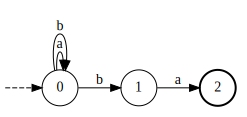

In [4]:
nfa = NFA(states=3, finals=[2], transitions={
    (0, 'a'): [0],
    (0, 'b'): [0, 1],
    (1, 'a'): [2]
})
nfa

![](cp6-files/0.svg)

Una vez construida la instancia las transiciones pueden accederse de forma más cómoda a través del campo `transitions`. Las transiciones están agrupadas por estado origen, y luego por símbolo: $(Q \to (V \to Q))$.

In [5]:
nfa.transitions

{0: {'a': [0], 'b': [0, 1]}, 1: {'a': [2]}, 2: {}}

### Autómatas finitos deterministas

Modelemos los autómatas finitos deterministas con la clase `DFA`. Esta clase extiende la clase `NFA` para:
- Usar la función de transición propia de los autómatas finitos deterministas.
- Implementar un algoritmo de reconocimiento de cadenas.

In [6]:
class DFA(NFA):
    
    def __init__(self, states, finals, transitions, start=0):
        assert all(isinstance(value, int) for value in transitions.values())
        assert all(len(symbol) > 0 for origin, symbol in transitions)
        
        transitions = { key: [value] for key, value in transitions.items() }
        NFA.__init__(self, states, finals, transitions, start)
        self.current = start
        
    def _move(self, symbol):
        # Your code here
        try:
            self.current = self.transitions[self.current][symbol][0]
        except KeyError:
            return False
        return True
    
    def _reset(self):
        self.current = self.start
        
    def recognize(self, string):
        # Your code here
        self._reset()
        for symbol in string:
            if not self._move(symbol):
                return False
        return self.current in self.finals


La instancia se construye de forma similar a los NFA, salvo por la forma de la función de transición que, en lugar de una colección de estados destino, contiene un único estado destino.

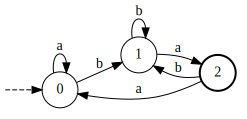

In [7]:
automaton = DFA(states=3, finals=[2], transitions={
    (0, 'a'): 0,
    (0, 'b'): 1,
    (1, 'a'): 2,
    (1, 'b'): 1,
    (2, 'a'): 0,
    (2, 'b'): 1,
})
automaton

![](cp6-files/1.svg)

El autómata anterior reconoce el lenguaje de las cadenas sobre `{a,b}*` que terminan en `ba`.

In [8]:
assert automaton.recognize('ba')
assert automaton.recognize('aababbaba')

assert not automaton.recognize('')
assert not automaton.recognize('aabaa')
assert not automaton.recognize('aababb')

## Equivalencia entre DFA y NFA

Como estudiamos en conferencia, los autómatas finitos deterministas y no deterministas tienen el mismo poder de reconocimiento: ambos reconocen la familia de lenguajes regulares. Dicha característica nos indica que deberían ser transformables los unos a los otros.

La transformación de DFA a NFA es bastante trivial, ya que un autómata finito determinista puede verse como uno no deterministas sin $\epsilon$-transiciones y en el que los conjuntos de estados destinos en las respectivas transiciones siempre tiene tamaño 1 (o 0). De hecho, eso es lo que hacemos en el constructor de la clase `DFA` que hereda de `NFA`.

La transformación de NFA a DFA se basa en simular las transiciones entre los posibles estados en los que puede estar a la vez el NFA durante el reconocimiento de cualquier cadena. Los estados de la versión transformada del NFA serán cada uno un subconjunto del conjunto de estados original. Sabemos que el número de posibles configuraciones de estados en los que puede estar a la vez es finito, ya que el número de estados del autómata es finito. Un autómata con $N$ estados puede tener a lo sumo $2^N$ posibles configuraciones de estados distintas.

El algoritmo clásico para convertir de NFA a DFA se apoya en 2 definiciones auxiliares:
- `move(T,a)`: conjunto de estados del NFA hacia los que hay una transición con el símbolo de entrada `a` desde algún estado de `T`.
- $\epsilon$-closure`(T)`: conjunto de estados del NFA alcanzables desde algún estado de `T` realizando únicamente $\epsilon$-transiciones.

In [9]:
from cmp.utils import ContainerSet

Trabajaremos con el siguiente autómata de ejemplo, que reconoce el lenguaje `c*|(a|b)d*`.

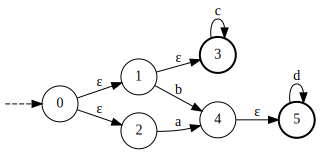

In [10]:
automaton = NFA(states=6, finals=[3, 5], transitions={
    (0, ''): [ 1, 2 ],
    (1, ''): [ 3 ],
    (1,'b'): [ 4 ],
    (2,'a'): [ 4 ],
    (3,'c'): [ 3 ],
    (4, ''): [ 5 ],
    (5,'d'): [ 5 ]
})
display(automaton)

Pasemos a computar `move(T,a)`. El método `move(automaton, states, symbol)` computa el conjunto `move(states, symbol)` con las transiciones registradas en `automaton`.

In [11]:
def move(automaton, states, symbol):
    moves = set()
    for state in states:
        # Your code here
        try:
            moves.update(set(automaton.transitions[state][symbol]))
        except KeyError:
            pass
    return moves

assert move(automaton, [1], 'a') == set()
assert move(automaton, [2], 'a') == {4}
assert move(automaton, [1, 5], 'd') == {5}

Pasemos a computar $\epsilon$-closure`(T)`. El método `epsilon_closure(automaton, states)` computa el conjunto $\epsilon$-closure`(states)` con las transiciones registradas en `automaton`.

In [12]:
def epsilon_closure(automaton, states):
    pending = [ s for s in states ] # equivalente a list(states) pero me gusta así :p
    closure = { s for s in states } # equivalente a  set(states) pero me gusta así :p
    
    while pending:
        state = pending.pop()
        # Your code here
        for x in automaton.epsilon_transitions(state):
            if x not in closure:
                closure.add(x)
                pending.append(x)
    return ContainerSet(*closure)

assert epsilon_closure(automaton, [0]) == {0,1,2,3}
assert epsilon_closure(automaton, [0, 4]) == {0,1,2,3,4,5}
assert epsilon_closure(automaton, [1, 2, 4]) == {1,2,3,4,5}

Finalmente implementemos el algoritmo para convertir de autómata finito no determinista a determinista.

In [13]:
def nfa_to_dfa(automaton):
    transitions = {}
    
    start = epsilon_closure(automaton, [automaton.start])
    start.id = 0
    start.is_final = any(s in automaton.finals for s in start)
    states = [ start ]

    pending = [ start ]
    while pending:
        state = pending.pop()
        
        for symbol in automaton.vocabulary:
            # Your code here
            # ...
            moves = move(automaton, state, symbol)
            e_closure = epsilon_closure(automaton, moves)
            if not e_closure:
                continue
            if e_closure not in states:
                e_closure.id = len(states)
                e_closure.is_final = any(s in automaton.finals for s in e_closure)
                states.append(e_closure)
                pending.append(e_closure)
            else:
                e_closure = states[states.index(e_closure)]
            try:
                transitions[state.id, symbol]
                assert False, 'Invalid DFA!!!'
            except KeyError:
                # Your code here
                transitions[state.id, symbol] = e_closure.id
                pass
    finals = [ state.id for state in states if state.is_final ]
    dfa = DFA(len(states), finals, transitions)
    return dfa

Comprobemos que funciona el algoritmo. El DFA resultante debería reconocer el mismo lenguaje que el NFA original: `c*|(a|b)d*`.

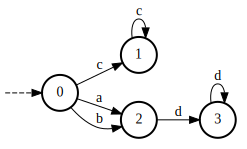

In [14]:
dfa = nfa_to_dfa(automaton)
display(dfa)

assert dfa.states == 4
assert len(dfa.finals) == 4

assert dfa.recognize('')
assert dfa.recognize('a')
assert dfa.recognize('b')
assert dfa.recognize('cccccc')
assert dfa.recognize('adddd')
assert dfa.recognize('bdddd')

assert not dfa.recognize('dddddd')
assert not dfa.recognize('cdddd')
assert not dfa.recognize('aa')
assert not dfa.recognize('ab')
assert not dfa.recognize('ddddc')

![](cp6-files/3.svg)

### Probando con otros autómatas

Qué lenguaje reconoce el siguiente autómata?

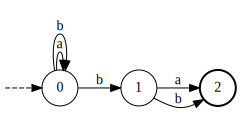

No sé que lenguaje reconoce :'(


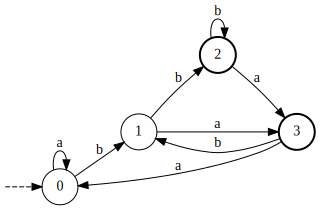

In [15]:
automaton = NFA(states=3, finals=[2], transitions={
    (0,'a'): [ 0 ],
    (0,'b'): [ 0, 1 ],
    (1,'a'): [ 2 ],
    (1,'b'): [ 2 ],
})
display(automaton)

print("No sé que lenguaje reconoce :'(")


assert move(automaton, [0, 1], 'a') == {0, 2}
assert move(automaton, [0, 1], 'b') == {0, 1, 2}

dfa = nfa_to_dfa(automaton)
display(dfa)

assert dfa.states == 4
assert len(dfa.finals) == 2

assert dfa.recognize('aba')
assert dfa.recognize('bb')
assert dfa.recognize('aaaaaaaaaaaba')

assert not dfa.recognize('aaa')
assert not dfa.recognize('ab')
assert not dfa.recognize('b')
assert not dfa.recognize('')

![](cp6-files/4.svg)
![](cp6-files/5.svg)

Y este?

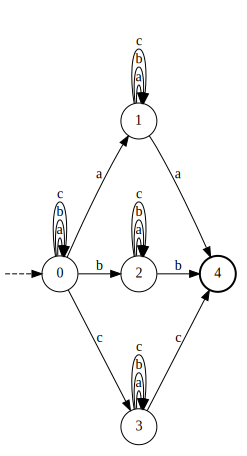

No sé que lenguaje reconoce :'(


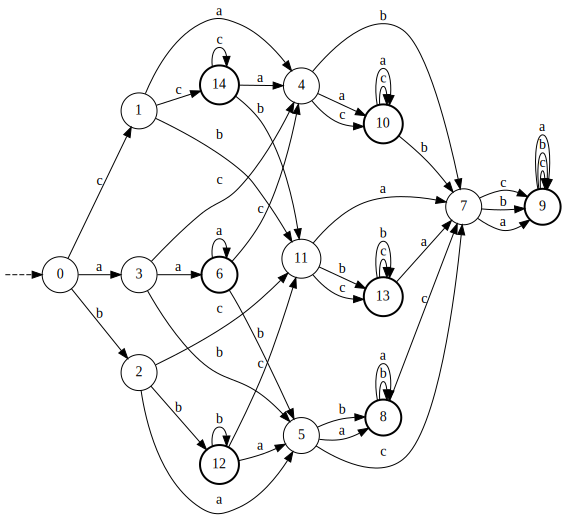

In [16]:
automaton = NFA(states=5, finals=[4], transitions={
    (0,'a'): [ 0, 1 ],
    (0,'b'): [ 0, 2 ],
    (0,'c'): [ 0, 3 ],
    (1,'a'): [ 1, 4 ],
    (1,'b'): [ 1 ],
    (1,'c'): [ 1 ],
    (2,'a'): [ 2 ],
    (2,'b'): [ 2, 4 ],
    (2,'c'): [ 2 ],
    (3,'a'): [ 3 ],
    (3,'b'): [ 3 ],
    (3,'c'): [ 3, 4 ],
})
display(automaton)

print("No sé que lenguaje reconoce :'(")

dfa = nfa_to_dfa(automaton)
display(dfa)

assert dfa.states == 15
assert len(dfa.finals) == 7

assert dfa.recognize('abccac')
assert dfa.recognize('bbbbbbbbaa')
assert dfa.recognize('cac')

assert not dfa.recognize('abbbbc')
assert not dfa.recognize('a')
assert not dfa.recognize('')
assert not dfa.recognize('acacacaccab')

![](cp6-files/6.svg)
![](cp6-files/7.svg)

Se le ocurre un autómata determinista para este lenguaje sin pasar por la transformación? 

## Propuestas

- Implemente un algoritmo para reconocer si una cadena pertenece o no al lenguaje denotado por un autómata finito no determinista. Evite utilizar `backtrack` o transformar completamente el NFA a DFA. 

{0: {'a': [1]}, 1: {'b': [0], 'a': [2]}, 2: {'b': [1], 'a': [3]}, 3: {'b': [2]}}


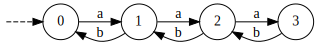

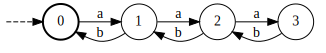

In [17]:
"""
Functions to analyze regular grammars.
"""

from cmp.pycompiler import Grammar, NonTerminal, Terminal
from cmp.automata import State
# from cmp.tools.automata import NFA, nfa_to_dfa

def is_regular(G: Grammar) -> bool:
    """
    Checks if grammar `G` is regular.
    """
    # Maybe can be ommited left part checking
    for prod in G.Productions:
        if len(prod.Left) != 1 or type(prod.Left) is not NonTerminal or \
        len(prod.Right) not in (1, 2) or Terminal not in (type(sym) for sym in prod.Right):
            return False
    return True


def grammar_to_dfa(G: Grammar) -> DFA:
    """
    Converts a regular grammar to a DFA.
    """
    mapping = {nonTerm: value for nonTerm, value in zip(G.nonTerminals, range(len(G.nonTerminals)))}
    transitions = {}
    final = len(G.nonTerminals)
    for prod in G.Productions:
        if prod.Right[0].IsTerminal:
            symbol = prod.Right[0].Name
            if len(prod.Right) == 1:
                go_state = final
            else:
                go_state = mapping[prod.Right[1]]
        else:
            symbol = prod.Right[1].Name
            go_state = mapping[prod.Right[0]]
        try:
            transitions[(mapping[prod.Left], symbol)].append(go_state)
        except KeyError:
            transitions[(mapping[prod.Left], symbol)] = [go_state]
        # print(mapping[prod.Left], symbol, '->', go_state,)
    nfa = NFA(
        states=final + 1,
        finals=[final],
        transitions=transitions,
        start=mapping[G.startSymbol]
    )
    return nfa
    # return nfa_to_dfa(nfa)


def dfa_to_regex():
    """
    Converts a DFA to an equivalent regex.
    """
    pass


"""
DEBUGGING
"""
# G = Grammar()
# A = G.NonTerminal('A', True)
# B = G.NonTerminal('B')
# a, b = G.Terminals('a b')

# A %= a + B
# B %= a + B | b + B | b 

G = Grammar()
A = G.NonTerminal('A', True)
B, C, D = G.NonTerminals('B C D')
a, b = G.Terminals('a b')

A %= a + B
B %= b + A
B %= a + C
C %= a + D
C %= b + B
D %= b + C

assert is_regular(G)
nfa = grammar_to_dfa(G)
dfa = nfa_to_dfa(nfa)
dfa.finals = [0]
print(dfa.transitions)
display(nfa)
display(dfa)
assert dfa.recognize('aaabbb')

In [18]:
from collections import OrderedDict

def printm(matrix):
    for row in matrix:
        print(row)
    print('------------')


def set_to_regex(s: set) -> str:
    # print(type(s), s)
    if len(s) > 0:
        regex = ''
        for x in s:
            regex += f'+{x}'
        return regex[1:]
    else:
        return ''


def dfa_to_regex(dfa: DFA) -> str:
    """
    Converts a DFA to an equivalent regex.
    """
    states = dfa.states
    M = [[set() for x in range(states)] for y in range(states)]
    for node in dfa.transitions.keys():
        for symbol in dfa.transitions[node]:
            M[dfa.transitions[node][symbol][0]][node].add(symbol)
    printm(M)

    # M[j][k] = M[j][k] + M[j][i](M[i][i])*M[i][k]
    for i in range(1, states):
        M_i_i = f'({set_to_regex(M[i - 1][i - 1])})*'
        M_i_i = '' if M_i_i == '()*' else M_i_i
        for j in range(0, i + 1):
            M_j_i = set_to_regex(M[j][i - 1])
            for k in range(0, i + 1):
                M_i_k = set_to_regex(M[i - 1][k])

                if j == i - 1:
                    regex = M_i_i + M_i_k
                    M[j][k] = set()
                    if regex != '':
                        M[j][k].add(regex)
                elif k == i - 1:
                    regex = M_j_i + M_i_i
                    M[j][k] = set()
                    if regex != '':
                        M[j][k].add(regex)
                else:
                    regex =  M_j_i + M_i_i + M_i_k
                    if regex != '':
                        print(f'M_{j}_{k}: {regex} = M_{j}_{i}: {M_j_i} + M_{i}_{i}: {M_i_i} + M_{i}_{k}: {M_i_k}')
                        M[j][k].add(regex)
                print('regex: ', regex)

        print('i= ', i)
        printm(M)
    return M

"""
DEBUGGING
"""
matrix = dfa_to_regex(dfa)
for row in matrix:
    print(row)
print('->', matrix[dfa.states-1][dfa.states-1])

[set(), {'b'}, set(), set()]
[{'a'}, set(), {'b'}, set()]
[set(), {'a'}, set(), {'b'}]
[set(), set(), {'a'}, set()]
------------
regex:  
regex:  b
regex:  a
M_1_1: ab = M_1_1: a + M_1_1:  + M_1_1: b
regex:  ab
i=  1
[set(), {'b'}, set(), set()]
[{'a'}, {'ab'}, {'b'}, set()]
[set(), {'a'}, set(), {'b'}]
[set(), set(), {'a'}, set()]
------------
M_0_0: b(ab)*a = M_0_2: b + M_2_2: (ab)* + M_2_0: a
regex:  b(ab)*a
regex:  b(ab)*
M_0_2: b(ab)*b = M_0_2: b + M_2_2: (ab)* + M_2_2: b
regex:  b(ab)*b
regex:  (ab)*a
regex:  (ab)*ab
regex:  (ab)*b
M_2_0: a(ab)*(ab)*a = M_2_2: a + M_2_2: (ab)* + M_2_0: (ab)*a
regex:  a(ab)*(ab)*a
regex:  a(ab)*
M_2_2: a(ab)*(ab)*b = M_2_2: a + M_2_2: (ab)* + M_2_2: (ab)*b
regex:  a(ab)*(ab)*b
i=  2
[{'b(ab)*a'}, {'b(ab)*'}, {'b(ab)*b'}, set()]
[{'(ab)*a'}, {'(ab)*ab'}, {'(ab)*b'}, set()]
[{'a(ab)*(ab)*a'}, {'a(ab)*'}, {'a(ab)*(ab)*b'}, {'b'}]
[set(), set(), {'a'}, set()]
------------
M_0_0: b(ab)*b(a(ab)*(ab)*b)*a(ab)*(ab)*a = M_0_3: b(ab)*b + M_3_3: (a(ab)*(ab)*